# Genetic Variant Classifications
---

In [333]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import EasyEnsemble
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import chi2
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
%matplotlib inline

## Import the dataset

In [295]:
df = pd.read_csv('./data/clinvar_conflicting.csv')
df.shape

/Users/rook/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(65188, 46)

In [296]:
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,955563,G,C,0.0000,0.00000,0.0000,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,11.390,1.133255,-2.0
1,1,955597,G,T,0.0000,0.42418,0.2826,MedGen:CN169374,NaN,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,8.150,0.599088,NaN
2,1,955619,G,C,0.0000,0.03475,0.0088,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,3.288,0.069819,1.0
3,1,957640,C,T,0.0318,0.02016,0.0328,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,12.560,1.356499,NaN
4,1,976059,C,T,0.0000,0.00022,0.0010,MedGen:CN169374,NaN,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,17.740,2.234711,NaN


### Binary class split

In [297]:
df['CLASS'].value_counts()

0    48754
1    16434
Name: CLASS, dtype: int64

### Data preprocessing

In [298]:
X = df.loc[:, ~df.columns.isin(['CLASS'])]
Y = df['CLASS']

In [299]:
# Converting to categorical
convert_cat = []
to_drop = []
unique = None

categorical = X.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    unique = column.nunique()
    print(unique)
    
    # drop cols with too many unique values     
    if unique <= 200:
        convert_cat.append(i)
    else:
        to_drop.append(i)

CHROM
25
REF
866
ALT
458
CLNDISDB
9234
CLNDISDBINCL
48
CLNDN
9260
CLNDNINCL
54
CLNHGVS
65188
CLNSIGINCL
68
CLNVC
7
CLNVI
26289
MC
89
Allele
374
Consequence
48
IMPACT
4
SYMBOL
2328
Feature_type
2
Feature
2369
BIOTYPE
2
EXON
3264
INTRON
1929
cDNA_position
13970
CDS_position
13663
Protein_position
7339
Amino_acids
1262
Codons
2220
BAM_EDIT
2
SIFT
4
PolyPhen
4
MOTIF_NAME
2
HIGH_INF_POS
1


In [300]:
print(f'convert_cat\n------\n{convert_cat} \n')
print(f'to_drop\n------\n{to_drop}')

convert_cat
------
['CHROM', 'CLNDISDBINCL', 'CLNDNINCL', 'CLNSIGINCL', 'CLNVC', 'MC', 'Consequence', 'IMPACT', 'Feature_type', 'BIOTYPE', 'BAM_EDIT', 'SIFT', 'PolyPhen', 'MOTIF_NAME', 'HIGH_INF_POS'] 

to_drop
------
['REF', 'ALT', 'CLNDISDB', 'CLNDN', 'CLNHGVS', 'CLNVI', 'Allele', 'SYMBOL', 'Feature', 'EXON', 'INTRON', 'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids', 'Codons']


### Drop all features with more than 85% NaN's

In [301]:
to_drop_nans = []

for c in convert_cat:
    if X[c].isnull().sum() / X.shape[0] > 0.85:
        print(f'{c}: {X[c].isnull().sum() / X.shape[0]}')
        to_drop_nans.append(c)

CLNDISDBINCL: 0.9988341412529913
CLNDNINCL: 0.9988341412529913
CLNSIGINCL: 0.9988341412529913
MOTIF_NAME: 0.9999693195066577
HIGH_INF_POS: 0.9999693195066577


In [302]:
X = X.loc[:, ~X.columns.isin(to_drop_nans)]

for item in to_drop_nans:
    convert_cat.remove(item)

In [303]:
convert_cat

['CHROM',
 'CLNVC',
 'MC',
 'Consequence',
 'IMPACT',
 'Feature_type',
 'BIOTYPE',
 'BAM_EDIT',
 'SIFT',
 'PolyPhen']

### Convert features to categorical - get_dummies

In [304]:
# Deleting duplicate rows
X = X.loc[:,~X.columns.duplicated()]

# Drop cols with too many unique values
X = X.loc[:, ~X.columns.isin(to_drop)]

# Get dummies - conver to categroical
X = pd.get_dummies(data=X, columns=convert_cat) 

In [305]:
X.head()

,POS,AF_ESP,AF_EXAC,AF_TGP,ORIGIN,SSR,DISTANCE,STRAND,MOTIF_POS,MOTIF_SCORE_CHANGE,...,BAM_EDIT_FAILED,BAM_EDIT_OK,SIFT_deleterious,SIFT_deleterious_low_confidence,SIFT_tolerated,SIFT_tolerated_low_confidence,PolyPhen_benign,PolyPhen_possibly_damaging,PolyPhen_probably_damaging,PolyPhen_unknown
0,955563,0.0000,0.00000,0.0000,1.0,NaN,NaN,1.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,955597,0.0000,0.42418,0.2826,1.0,NaN,NaN,1.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,955619,0.0000,0.03475,0.0088,1.0,NaN,NaN,1.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,957640,0.0318,0.02016,0.0328,1.0,NaN,NaN,1.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,976059,0.0000,0.00022,0.0010,1.0,NaN,NaN,1.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [306]:
# get_dummies drops NaN values, so we have to return them
X['MC_SO:0001574|splice_acceptor_variant'].isnull().sum()

0

In [307]:
# Return all NaN values to dummy features
for feature in convert_cat:
    if df[feature].isnull().sum() > 0:
        X.loc[df[feature].isnull(), X.columns.str.startswith(feature + "_")] = np.nan

In [308]:
# After returning NaN values
X['MC_SO:0001574|splice_acceptor_variant'].isnull().sum()

6969

We can see that the NaN values have been returned to the categorical features.

### Finding all NaN rows

In [309]:
nans = lambda X: X[X.isnull().any(axis=1)]
len(nans(X))

65188

Every row in the dataset has a null attribute.  Imputing data wiil be a necessity here.

### Numerical Imputer

In [310]:
cat_feat = []

for feature in convert_cat:
    for col in X.loc[:, X.columns.str.startswith(feature + "_")].columns:
        cat_feat.append(col)
        
numerical_data = X.loc[:, ~X.columns.isin(X[cat_feat])]

print(numerical_data.columns)

Index(['POS', 'AF_ESP', 'AF_EXAC', 'AF_TGP', 'ORIGIN', 'SSR', 'DISTANCE',
       'STRAND', 'MOTIF_POS', 'MOTIF_SCORE_CHANGE', 'LoFtool', 'CADD_PHRED',
       'CADD_RAW', 'BLOSUM62'],
      dtype='object')


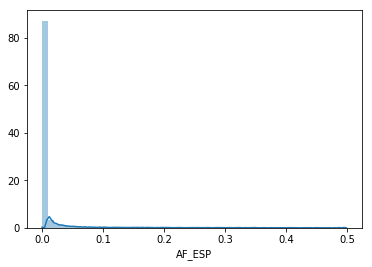

In [311]:
sns.distplot(X['AF_ESP'])

We can see that these numerical features are not normally distributed.  So we will use the median to impute the data. 

In [312]:
# For numerical data, impute using mean OR median values
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
imp = imp.fit(numerical_data)

# Impute our data
X[numerical_data.columns] = imp.transform(numerical_data)

In [313]:
nans = lambda X: X[X.isnull().any(axis=1)]
len(nans(X))

53112

We can see that the number of rows with NaN values has decreased.

### Categorical Imputer

In [314]:
# BEFORE IMPUTING - Ranodm dummy variable with NaN values
X['MC_SO:0001574|splice_acceptor_variant'].isnull().sum()

6969

In [315]:
for feature in convert_cat:
    if df[feature].isnull().sum() > 0:
        dummy_features = X.loc[:, X.columns.str.startswith(feature + "_")]
        
        # For categorical data, impute using mode values
        imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
        imp = imp.fit(dummy_features)

        # Impute the data
        X[dummy_features.columns] = imp.transform(dummy_features)

In [316]:
# AFTER IMPUTING - Ranodm dummy variable with NaN values
X['MC_SO:0001574|splice_acceptor_variant'].isnull().sum()

0

There are no longer any NaN values in the categorical features.

In [318]:
nans = lambda X: X[X.isnull().any(axis=1)]
len(nans(X))

0

Now we have zero rows with NaN values in the dataset.

### VarianceThreshold

In [319]:
# Removes all low-variance features
def variance_threshold_selector(data, threshold=0.95):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

vt_to_drop = variance_threshold_selector(X)

vt_to_drop.head()

,POS,ORIGIN,DISTANCE,STRAND,CADD_PHRED,CADD_RAW,BLOSUM62
0,955563.0,1.0,469.0,1.0,11.390,1.133255,-2.0
1,955597.0,1.0,469.0,1.0,8.150,0.599088,-1.0
2,955619.0,1.0,469.0,1.0,3.288,0.069819,1.0
3,957640.0,1.0,469.0,1.0,12.560,1.356499,-1.0
4,976059.0,1.0,469.0,1.0,17.740,2.234711,-1.0


In [320]:
X = X.loc[:, ~X.columns.isin(vt_to_drop)]

### Display correlation Matrix to identify features that need to be dropped

In [321]:
correlation_matrix = X.corr()
display(correlation_matrix)

,AF_ESP,AF_EXAC,AF_TGP,SSR,MOTIF_POS,MOTIF_SCORE_CHANGE,LoFtool,CHROM_1,CHROM_2,CHROM_3,...,BAM_EDIT_FAILED,BAM_EDIT_OK,SIFT_deleterious,SIFT_deleterious_low_confidence,SIFT_tolerated,SIFT_tolerated_low_confidence,PolyPhen_benign,PolyPhen_possibly_damaging,PolyPhen_probably_damaging,PolyPhen_unknown
AF_ESP,1.000000e+00,8.518704e-01,8.077414e-01,-2.916374e-03,NaN,1.906514e-19,2.452981e-02,2.326319e-02,-2.182190e-02,6.794538e-03,...,-9.924762e-03,9.924762e-03,-8.830373e-02,-1.142306e-02,-1.743307e-02,3.054199e-03,9.086722e-02,-4.396333e-02,-7.556392e-02,3.099066e-03
AF_EXAC,8.518704e-01,1.000000e+00,8.056343e-01,8.312354e-03,NaN,7.267337e-19,2.311371e-02,1.657149e-02,-1.881784e-02,7.828141e-03,...,-7.886328e-03,7.886328e-03,-8.604587e-02,-9.234471e-03,-2.055712e-02,3.787363e-03,8.852378e-02,-4.422128e-02,-7.266128e-02,6.393419e-03
AF_TGP,8.077414e-01,8.056343e-01,1.000000e+00,-3.013060e-03,NaN,8.206474e-19,2.518909e-02,1.873285e-02,-2.387240e-02,1.592622e-03,...,-1.056173e-02,1.056173e-02,-9.318508e-02,-1.186737e-02,-1.961782e-02,2.810568e-03,9.499409e-02,-4.594331e-02,-7.912733e-02,8.101307e-03
SSR,-2.916374e-03,8.312354e-03,-3.013060e-03,1.000000e+00,NaN,1.717082e-20,5.285204e-03,1.992701e-03,-4.594735e-03,4.400490e-03,...,-7.464638e-04,7.464638e-04,-2.013132e-03,1.075740e-02,-2.006663e-03,-1.523032e-03,-1.429439e-03,2.507033e-03,-1.623454e-04,-9.205066e-05
MOTIF_POS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MOTIF_SCORE_CHANGE,1.906514e-19,7.267337e-19,8.206474e-19,1.717082e-20,NaN,1.000000e+00,9.841945e-19,5.996419e-19,8.739546e-19,6.586718e-19,...,2.125066e-19,-2.125066e-19,6.496897e-19,1.323679e-19,8.627214e-19,4.823063e-19,-7.993806e-19,4.243484e-19,9.757325e-19,2.576834e-20
LoFtool,2.452981e-02,2.311371e-02,2.518909e-02,5.285204e-03,NaN,9.841945e-19,1.000000e+00,-4.228210e-02,1.864574e-01,-4.716660e-02,...,-3.960430e-02,3.960430e-02,-6.180982e-02,-2.092804e-02,-2.624129e-03,-2.306196e-02,8.566406e-02,-2.864046e-02,-8.071423e-02,4.689172e-04
CHROM_1,2.326319e-02,1.657149e-02,1.873285e-02,1.992701e-03,NaN,5.996419e-19,-4.228210e-02,1.000000e+00,-1.058893e-01,-5.440538e-02,...,-1.720285e-02,1.720285e-02,2.752707e-03,-7.826771e-03,-1.781902e-02,2.105153e-03,4.708965e-03,-8.595165e-03,8.446994e-04,-2.121381e-03
CHROM_2,-2.182190e-02,-1.881784e-02,-2.387240e-02,-4.594735e-03,NaN,8.739546e-19,1.864574e-01,-1.058893e-01,1.000000e+00,-7.855535e-02,...,-2.483902e-02,2.483902e-02,-3.477825e-02,-2.452850e-02,-1.958588e-02,-2.584160e-02,4.807791e-02,-2.269305e-02,-4.043020e-02,2.711206e-03
CHROM_3,6.794538e-03,7.828141e-03,1.592622e-03,4.400490e-03,NaN,6.586718e-19,-4.716660e-02,-5.440538e-02,-7.855535e-02,1.000000e+00,...,-1.276215e-02,1.276215e-02,9.764309e-03,-1.030979e-02,-3.654833e-03,3.874598e-03,-6.286881e-03,1.483380e-02,-3.521129e-03,-1.573773e-03


In [322]:
# Correlated features to be dropped
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
print(to_drop)

['CHROM_16', 'CHROM_16', 'Consequence_frameshift_variant', 'Consequence_intergenic_variant', 'Consequence_splice_acceptor_variant', 'Consequence_splice_donor_variant', 'Consequence_stop_gained', 'Consequence_synonymous_variant', 'IMPACT_MODERATE', 'Feature_type_MotifFeature']


In [323]:
cols = list(X.columns)

for col in to_drop: 
    cols.remove(col)

len(cols)

X = X[cols]

In [ ]:
# Save for future reference
X.to_csv('./data/X_var.csv')

## Train / Test splits

In [408]:
# Train splits
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.40, random_state=42, stratify=Y)

# Dev and Test splits
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

## Logistic Regression

In [422]:
lr = LogisticRegression()
lr_fit = lr.fit(X_train, y_train)

# Cross validation
scores_log_r = cross_val_score(lr, X_train, y_train, cv=5)

print(f'Average: {np.round(np.mean(scores_log_r), 4)} (+/- {np.round(scores_log_r.std()*2, 5)})')

Average: 0.7479 (+/- 3e-05)


## Logistic Regression Grid Search

In [423]:
lr_gs = LogisticRegression()

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

grid_log_r = GridSearchCV(lr_gs, param_grid=hyperparameters, cv=5)
grid_log_r.fit(X_train, y_train)

print('Best Score:', grid_log_r.best_score_)

# Best parameters from the grid search
best_params = grid_log_r.best_params_
print('Best Parameters:', best_params)

Best Score: 0.7479034567396196
Best Parameters: {'C': 1.0, 'penalty': 'l2'}


In [424]:
# Create a model with the best params
lr_2 = LogisticRegression(**best_params)

# Fit the model
lr_2_fit = lr_2.fit(X_train, y_train)

print('Train Accuracy')
print(lr_2_fit.score(X_train, y_train))

print('Dev Accuracy')
print(lr_2_fit.score(X_dev, y_dev))

Train Accuracy
0.7479034567396196
Dev Accuracy
0.7478907807946004


## Random Forest

In [326]:
rfc = ensemble.RandomForestClassifier(n_estimators=200, n_jobs=-1)

In [327]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

## Evaluation

In [328]:
# Train accuracy
print(f'Train Score: {rfc.score(X_train, y_train)}')
# Dev accuracy
print(f'Dev Score: {rfc.score(X_dev, y_dev)}')

Train Score: 0.9506289629781142
Dev Score: 0.7448995244669427


In [329]:
y_pred_train = rfc.predict_proba(X_train)[:,1]
auc_train = roc_auc_score(y_train, y_pred_train)
print('AUC train', auc_train)

AUC train 0.9847000371535423


In [330]:
y_pred_dev = rfc.predict_proba(X_dev)[:,1]
auc_dev = roc_auc_score(y_dev, y_pred_dev)
print('AUC dev', auc_dev)

AUC dev 0.7438331428536484


In [360]:
rf_acc = cross_val_score(rfc, X_train, y_train, cv=5)

In [362]:
print(f'Cross Val: {rf_acc}')
print(f'Average: {np.round(np.mean(rf_acc), 4)} (+/- {np.round(rf_acc.std()*2, 5)})')

Cross Val: [0.73565128 0.74945673 0.74558936 0.74571721 0.73804654]
Average: 0.7429 (+/- 0.01036)


## Random Forest Grid Search

In [350]:
parameters = {'n_estimators':[100,300,500],
             'max_features':['sqrt', 'log2'],
             'min_samples_split':[2,8,20],
             'max_depth':[5,6,7,8]}

# Instantiating and fitting Grid Search, then printing best score and best parameters
grid_rfc = GridSearchCV(rfc, param_grid=parameters, cv=5, n_jobs=-1)
grid_rfc.fit(X_train, y_train)

print('Best Score:', grid_rfc.best_score_)
best_params_rfc = grid_rfc.best_params_
print('Best Parameters:', best_params_rfc)

Best Score: 0.6595418285948047
Best Parameters: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 20, 'n_estimators': 100}


In [370]:
rfc_2 = ensemble.RandomForestClassifier(**best_params_rfc, n_jobs=-1)
# Fit the model
rfc_2.fit(X_train, y_train)

# Train accuracy
print(f'Train Score: {np.round(rfc.score(X_train, y_train), 4)}')
# Dev accuracy
print(f'Dev Score: {np.round(rfc.score(X_dev, y_dev), 4)}')

Train Score: 0.9506
Dev Score: 0.7449


## Gradient Boosting

In [409]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 700,
          'max_depth': 3,
          'loss': 'deviance'}

# Initialize and fit the model.
gb_clf = ensemble.GradientBoostingClassifier(**params)
gb_acc = cross_val_score(gb_clf, X_train, y_train, cv=5)

print(gb_acc)
print(f'Average: {np.round(np.mean(gb_acc), 4)} (+/- {np.round(gb_acc.std()*2, 5)})')

[0.75853253 0.76748051 0.76144209 0.7692406  0.76809   ]
Average: 0.765 (+/- 0.0084)


Gradient Boosting seems to perform slightly better than the Random Forest model

## Gradient Boosting Grid Search

In [412]:
parameters = {
            'loss':['deviance', 'exponential'],
            'min_samples_split':[2, 5, 10],
            'max_depth':[5,6,7,8],
            'max_features':['sqrt', 'log2'],
            'n_estimators':[100,300,600]}

#fitting model and printing best parameters and score from model
grid_gb = GridSearchCV(gb_clf, param_grid=parameters, n_jobs=2)
grid_gb.fit(X_train, y_train)

print('Best Score:', grid_gb.best_score_)
best_params_gb = grid_gb.best_params_
print('Best Parameters:', best_params_gb)

Best Score: 0.7665678052771528
Best Parameters: {'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 600}


In [425]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'loss': 'exponential', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 800}

# Initialize and fit the model.
gb_clf_2 = ensemble.GradientBoostingClassifier(**params)
gb_clf_2.fit(X_train, y_train)

print(f'Train Score: {gb_clf_2.score(X_train, y_train)}')
print(f'Dev Score: {gb_clf_2.score(X_dev, y_dev)}')
print(f'Test Score: {gb_clf_2.score(X_test, y_test)}')

Train Score: 0.860477602781755
Dev Score: 0.7741984967019482
Test Score: 0.767142199723884


Gradient Boosting seems to be must better in regards generalization.